# Homework 08: Conjugate Gradient Descent

In this homework, we will implement the conjugate graident descent algorithm. While you should nearly always use an optimization routine from a library for practical data analyiss, this exercise is useful because it will make concepts from multivariatble calculus and linear algebra covered in the lectrures concrete for you. Also, it brings you up the learning curve for the implementation of more complex algorithms than the ones you have been exposed to so far.

Note: The exercise assumes that we can calculate the gradient and Hessian of the function that we are trying to minimize. This can be computationally expensive or not even possible for some functions. Approximate methods can then be used; we do not go into such complexities here.

**Conjugate gradient descent**

We want to implement the line search method 

$$ 
x_{k+1} = x_k + \alpha_k p_k
$$

where $\alpha_k$ is the step size and $p_k$ is the search direction. 

In particular, we want the search directions $p_k$ to be *conjugate*, as this will allow us to find the minimum in $n$ steps for $x \in \mathbb{R}^n$ if $f(x)$ is a quadratic function.

The following exercises will unpack this:

- What quadratic functions are
- What conjugate vectors are
- How to find conjugate vectors by Gram-Schmidt process
- How to find the step size $\alpha_k$

and finally wrap them all into a conjugate gradient algorithm.

**Quadratic function surfaces**

Recall that our objective is to minimize a scalar valued function which maps $\mathbb{R}^n \mapsto \mathbb{R}$, for example, a log likelihoood function (for MLE) or unnormalized posterior distribution (for MAP). Geometrically, we are tring to find the value of the lowest point of some surface. The conjugate gradient algorihtm assumes that the surface can be approximated by the quadratic expression (say, by using a Taylor series expansion about $x$)

$$
f(x) = \frac{1}{2}x^TAx - b^Tx + c
$$

and that 

$$
\nabla f = Ax - b = 0
$$

at the minimum (if A is positive definite). Note that $A$ is a matrix, $b$ is a vector, and $c$ is a scalar.  Also, note that the matrix $A$ is the Hessian of the quadratic function.For simplicity, we'll work in $\mathbb{R}^2$ so we can visualize the surface, so that $x$ is a 2D-vector.

Note: A **form** is a polynomial function where every term has the same degree - for example, $x^2 + 2xy + y^2$ is a quadratic form, which can be rewritten as 
$$
\begin{pmatrix}
x & y
\end{pmatrix}
\begin{pmatrix}
    1 & 1\\
    1 & 1
\end{pmatrix}
\begin{pmatrix}
x \\
y
\end{pmatrix}
$$

That is, $x^TAx$ is a quadratic form.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

**Exercise 1 (20 points)** 

We will work with function $f_1$

$$
f1(x) = \frac{1}{2} x^T \pmatrix{1 & 0 \\ 0 & 1}x
$$

and function $f_2$

$$
f2(x) = \frac{1}{2} x^T \pmatrix{1 & 0 \\ 0 & 3}x
$$

- Plot the labeled contours of the quadratic functions
- Use a `streamplot` to show the gradient vector field of the above quadratic functions.

*First, I define the functions, f1 and f2*

In [2]:
def f1(x1, x2):
    """Return f1 given inputs, x1 and x2"""
    return 0.5 * (x1**2 + x2**2)

In [3]:
def f2(x1, x2):
    """Return f2 given inputs, x1 and x2"""
    return 0.5 * (x1**2 + 3 * x2**2)

*Next, I plot the contours of the quadratic functions*

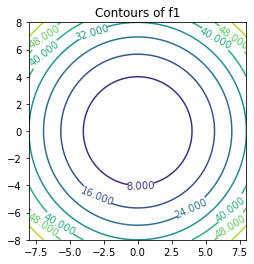

In [4]:
# Plot contours for f1
x = np.linspace(-8, 8, 100)
y = np.linspace(-8, 8, 100)
X, Y = np.meshgrid(x, y)
Z1 = f1(X, Y)
plt1 = plt.contour(X, Y, Z1)
plt.clabel(plt1, inline = 1, fontsize = 10)
plt.axis('square');
plt.title('Contours of f1');

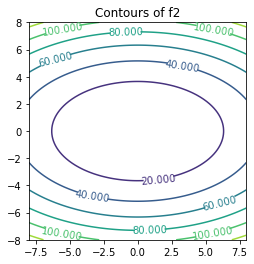

In [5]:
# Plot contours for f2, using same x and y range that was used for f1
Z2 = f2(X, Y)
plt2 = plt.contour(X, Y, Z2)
plt.clabel(plt2, inline = 1, fontsize = 10)
plt.axis('square');
plt.title('Contours of f2');

*Next, I use a `streamplot` to show the gradient vector field of the above quadratic functions*

*Note that the 3rd and 4th positional arguments are the partial derivatives with respect to x and y respectively*

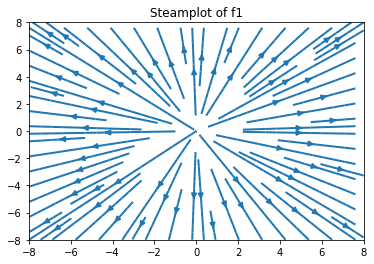

In [6]:
plt.streamplot(X, Y, X, Y, linewidth=2);
plt.title('Steamplot of f1');

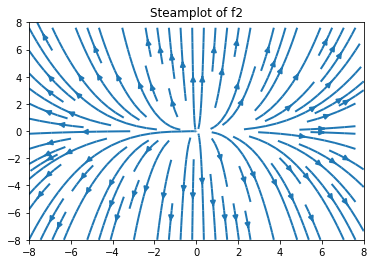

In [7]:
plt.streamplot(X, Y, X, 3 * Y, linewidth=2);
plt.title('Steamplot of f2');

**Gram-Schmidt**

The way to numerically find conjugate vectors is to use the Gram-Schmidt process. Here, instead of the usual projection 

$$
\text{proj}_u(v) = \frac{u \cdot v}{u \cdot u} \, u
$$

we use the generalized projection
$$
\text{proj}_u(v) = \frac{uA^Tv}{uA^Tu} \, u
$$

**Exercise 2 (30 points)**

The vectors $u$ and $v$ are orthogonal i.e. $u^Tv = 0$ and conjugate with respect to $A$ if $u^TAv = 0$. The geometric intuition for conjugate vecrors $u$ and $v$ is that $u$ and $v$ would be orthogonal if we stretched the contour plots so that it became isotropic (same in all directions, just like when A=𝟙). Write a Gram-Schmidt function to find orthogonal and conjuate vectors with the following signature

```python
def gram_schmidt(U, inner):
    """Return an orthogonal matrix.
    
    U is a matrix of (column) vectors.
    inner is a function that calculates the inner product.
    
    Returns an orthogonal matrix of the same shape as U.
    """
```

Use this function and the appropiate inner product to plot

- An orthogonal set of basis vectors for $f_1$
- A conjugate set of basic vectors for $f_2$ 

where the first basis vector is to parallel to $\pmatrix{1 \\ 1}$.

Questions:

- Confirm: Is the `A` simply the `A` given in the function definition?
- What is U? Does U have to be 2x2?
    - If U is not 2x2, what does it mean that the first basis vector is parallel to (1 1)?

In [35]:
def inner_f1(v1, v2):
    """Calculate inner product of input vectors, v1 and v2, for function 1"""
    return v1.T @ np.array([[1, 0], [0, 1]]) @ v2

In [ ]:
def inner_f2(v1, v2):
    """Calculate inner product of input vectors, v1 and v2, for function 2"""
    return v1.T @ np.array([[1, 0], [0, 3]]) @ v2

In [45]:
def gram_schmidt(U, inner):
    """Return an orthogonal matrix.

    U is a matrix of (column) vectors.
    inner is a function that calculates the inner product.

    Returns an orthogonal matrix of the same shape as U.
    """
    
    # Initialize result and set basis vector equal to first column of U
    res = np.zeros(shape = U.shape)
    res[:, 0] = U[:, 0] 
    
    # Find remaining basis vectors
    for i in range(1, U.shape[1]):
        proj_sum = np.zeros(U.shape[0])
        for j in range(i):
            proj_sum += inner(U[:, i], res[:, j]) / inner(res[:, j], res[:, j]) * res[:, j]
        res[:, i] = U[:, i] - proj_sum
    
    # Return orthogonal matrix
    return res / np.sqrt(np.sum(res ** 2, axis = 0))

In [46]:
gram_schmidt(U, inner_f1)

array([[ 0.31622777,  0.9486833 ],
       [ 0.9486833 , -0.31622777]])

**Exercise 3 (20 points)**

We now need to find the "step size" $\alpha$ to take in the direction of the search vector $p$. We can get a quadratic approximation to a general nonliner function $f$ by taking the Taylor series in the driection of $p$

$$
f(x + \alpha p) = f(x) + \alpha [f'(x)]^T p + \frac{\alpha^2}{2} p^T f''(x) p
$$

Find the derivative with respect to $\alpha$ and use this to find the optimal value for $\alpha$ with respect to the quadratic approximation. 

* Write the derivation of the optimal step size $\alpha$ using LaTeX in a Markdown cell.
* Write a funciton that returns $\alpha$ for a quadratic funciton with the following signature

```python
def step(x, p, A, b):
    """Returns the optimal step size to take in line search on a quadratic.
    
    A and b are the coefficients of the quadartic expression 
    $$
    f(x) = \frac{1}{2}x^TAx - b^Tx + c
    $$
    p is the search direction
    x is the current location
    """
```

**Line search**

We now know how to find a search direction $p_k$ - this is a vector that is conjugate to the previous search direction. The first search direction is usually set to be the gradient. Next we need to find out how far along $p_k$ we need to travel, i.e., we need to find $\alpha_k$. First we take a Taylor expansion in the direction of $p$

$$
f(x + \alpha p) = f(x) + \alpha [f'(x)]^T p + \frac{\alpha^2}{2} p^T f''(x) p
$$

followed by finding the derivative with respect to $\alpha$

$$
\frac{d}{d\alpha} f(x + \alpha p) = [f'(x)]^T p + \alpha p^T f''(x) p
$$

Solvign for $\frac{d}{d\alpha} f(x + \alpha p) = 0$, we get

$$
\alpha = - \frac{[f'(x)]^T p}{p^T f''(x) p} \\
= - \frac{\nabla f^T p}{p^T A p} \\
= \frac{(b - Ax)^T p}{p^T A p}
$$



**Exercise 4 (30 points)**

Implement the conjugate gradient descent algorithm with the following signature

```python
def cg(x, A, b, c, max_iter=100, tol=1e-3):
    """Conjugate gradient descent on a quadratic function surface.
    
    x is the starting position
    A, b and c are the coefficients of the quadartic expression 
    $$
    f(x) = \frac{1}{2}x^TAx - b^Tx + c
    $$
    max_iter is the maximum number of iterations to take
    tol is the tolerance (stop if the length of the gradient is smaller than tol)

    Returns the number of steps taken and the list of all positions visited.
    """
```

- Use cg to find the minimum of the funciton $f_2$ from Exercise 1, starting from $\pmatrix{6 \\ 7}$.

- Plot the contour of the funciton f and the trajectory taken from the inital starting poitn $x$ to the final position, inlcuding all the intermediate steps. 

We are not particularly concerned about efficiency here, so don't worry about JIT/AOT/C++ level optimization. 